# Shrinkage estimation of large covariance matrices: Keep it simple, statistician?, Olivier Ledoit Michael Wolf 

## Reproduction and personnal Analysis

In [59]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh, inv

# ─────────────────── SPD helpers ─────────────────────────────
logm_spd   = lambda A: (lambda w, V: V @ np.diag(np.log(w)) @ V.T)(*eigh(A))
sqrtm_spd  = lambda A: (lambda w, V: V @ np.diag(np.sqrt(w)) @ V.T)(*eigh(A))

def compute_losses(S_hat, iS_hat, Sigma, iSigma, sqrtSig, invSqrtSig, p):
    """
    Given:
      - S_hat     : estimated covariance matrix
      - iS_hat    : inverse of S_hat
      - Sigma     : true covariance matrix
      - iSigma    : inverse of Sigma
      - sqrtSig   : Sigma^(1/2)
      - invSqrtSig: Sigma^(-1/2)
      - p         : dimension

    Returns a dict mapping each of the 12 row‐labels to its scalar loss.
    """
    losses = {}
    I_p = np.eye(p)

    # 1) Frobenius
    losses["Frobenius"] = np.linalg.norm(S_hat - Sigma, 'fro')**2 / p

    # 2) Inverse‐Stein:
    M1 = Sigma @ iS_hat
    losses["Inv-Stein"] = (np.trace(M1) - np.linalg.slogdet(M1)[1] - p) / p

    # 3) Min‐Var: 
    tr_iS = np.trace(iS_hat)
    losses["Min-Var"] = np.trace(iS_hat @ Sigma @ iS_hat) / (tr_iS**2)

    # 4) Stein: 
    M2 = S_hat @ iSigma
    losses["Stein"] = (np.trace(M2) - np.linalg.slogdet(M2)[1] - p) / p

    # 5) Inv‐Frobenius: 
    losses["Inv-Frobenius"] = np.linalg.norm(iS_hat - iSigma, 'fro')**2 / p

    # 6) Sym‐Stein: 
    losses["Sym-Stein"] = (np.trace(S_hat @ iSigma + iS_hat @ Sigma) - 2*p) / p

    # 7) Weighted‐Frob: 
    D = invSqrtSig @ (S_hat - Sigma) @ invSqrtSig
    losses["Weighted-Frob"] = np.linalg.norm(D, 'fro')**2 / p

    # 8) Disutility: 
    E = sqrtSig @ (iS_hat - iSigma) @ sqrtSig
    losses["Disutility"] = np.linalg.norm(E, 'fro')**2 / p

    # 9) Log‐Euclid: 
    losses["Log-Euclid"] = np.linalg.norm(logm_spd(S_hat) - logm_spd(Sigma), 'fro')**2 / p

    # 10) Fréchet: 
    losses["Frechet"] = np.linalg.norm(sqrtm_spd(S_hat) - sqrtm_spd(Sigma), 'fro')**2 / p

    # 11) Quadratic: 
    losses["Quadratic"] = np.linalg.norm(iSigma @ S_hat - I_p, 'fro')**2 / p

    # 12) Inv‐Quadratic: 
    losses["Inv-Quadratic"] = np.linalg.norm(iS_hat @ Sigma - I_p, 'fro')**2 / p

    return losses

# ───────────────── common settings ─────────────────────────────
p, n    = 100, 200
N_sim   = 1000
eig_pop = np.array([1]*20 + [3]*40 + [10]*40)
rng     = np.random.default_rng(0)

EST     = ["Identity", "Sample", "Linear"]
ROWS    = [
    "Frobenius",     "Inv-Stein",   "Min-Var",    "Stein",
    "Inv-Frobenius", "Sym-Stein",   "Weighted-Frob","Disutility",
    "Log-Euclid",    "Frechet",     "Quadratic",  "Inv-Quadratic"
]

# ─── Initialize accumulators ─────────────────────────────────
loss_acc_frech       = {r: 0.0 for r in ROWS}
loss_shrink1         = {r: 0.0 for r in ROWS}
loss_shrink2         = {r: 0.0 for r in ROWS}
Loss_ISL             = {row: {e: 0.0 for e in EST} for row in ROWS}
Loss_oracle          = {row: 0.0 for row in ROWS}
loss_LE              = {row: 0.0 for row in ROWS}

loss_inv_frob_spec   = {r: 0.0 for r in ROWS}
loss_sym_stein_spec  = {r: 0.0 for r in ROWS}

for _ in range(N_sim):
    # 1) Build true Σ and data X
    Q, _    = np.linalg.qr(rng.normal(size=(p, p)))
    Sigma   = Q @ np.diag(eig_pop) @ Q.T
    Sig12   = Q @ np.diag(np.sqrt(eig_pop)) @ Q.T
    X       = Sig12 @ rng.normal(size=(p, n))
    S_unb   = (X @ X.T) / (n - 1)    # unbiased
    S_biased= (X @ X.T) / n          # biased

    # 2) Eigendecompose Σ
    tau, Vp = eigh(Sigma)
    tau     = tau[::-1]
    Vp      = Vp[:, ::-1]

    invTau     = 1.0 / tau
    inv2Tau    = invTau**2
    Tau_sq     = tau**2

    Sigma_inv   = Vp @ np.diag(invTau)   @ Vp.T
    Sigma_inv2  = Vp @ np.diag(inv2Tau)  @ Vp.T
    Sigma_sq    = Vp @ np.diag(Tau_sq)   @ Vp.T

    sqrtSig     = Vp @ np.diag(np.sqrt(tau)) @ Vp.T
    invSqrtSig  = inv(sqrtSig)
    iSigma      = Sigma_inv
    I_p         = np.eye(p)

    # 3) Eigendecompose sample covariances
    d_unb, U_unb     = eigh(S_unb)
    d_unb            = d_unb[::-1]
    U_unb            = U_unb[:, ::-1]

    d_biased, U_biased = eigh(S_biased)
    d_biased          = d_biased[::-1]
    U_biased          = U_biased[:, ::-1]

    # 4) Frechét‐oracle eigenvalues & matrices
    a = np.empty(p, dtype=float)
    for i in range(p):
        u_i     = U_unb[:, i]
        innerF  = float(u_i @ (sqrtSig @ u_i))
        a[i]    = innerF**2

    S_FRE   = U_unb @ np.diag(a)    @ U_unb.T
    iS_FRE  = U_unb @ np.diag(1.0 / a) @ U_unb.T

    lam1, lam2 = np.empty(p), np.empty(p)
    for i in range(p):
        u_i    = U_unb[:, i]
        num1   = float(u_i @ (Sigma_inv  @ u_i))
        den1   = float(u_i @ (Sigma_inv2 @ u_i))
        lam1[i]= num1 / den1
        num2   = float(u_i @ (Sigma_sq @ u_i))
        den2   = float(u_i @ (Sigma    @ u_i))
        lam2[i]= num2 / den2

    S_shrink1  = U_unb @ np.diag(lam1)    @ U_unb.T
    iS_shrink1 = U_unb @ np.diag(1.0/lam1) @ U_unb.T

    S_shrink2  = U_unb @ np.diag(lam2)    @ U_unb.T
    iS_shrink2 = U_unb @ np.diag(1.0/lam2) @ U_unb.T

    # 6) Identity / Sample / Linear estimators
    mu       = np.trace(S_biased) / p
    S_id     = mu * np.eye(p)
    S_sample = S_biased

    # Ledoit‐Wolf linear shrinkage
    delta     = np.linalg.norm(S_sample - mu*np.eye(p), 'fro')**2
    normS_sq  = np.linalg.norm(S_sample, 'fro')**2
    X_cols    = X.T
    norm_x_sq = np.einsum('ij,ij->i', X_cols, X_cols)
    S_times_X = S_sample @ X
    dot_x_S_x = np.einsum('ij,ij->j', X, S_times_X)
    v         = norm_x_sq**2 - 2*dot_x_S_x + normS_sq
    phi_hat   = np.sum(v) / (n**2)
    alpha     = max(0.0, min(phi_hat / delta, 1.0))
    S_lin     = (1 - alpha)*S_sample + alpha*mu*np.eye(p)

    Est_ISL = {"Identity": S_id, "Sample": S_sample, "Linear": S_lin}

    # 7) Oracle (spectral) estimator
    S_U       = Sigma @ U_biased
    d_oracle  = np.sum(U_biased * S_U, axis=0)
    S_oracle  = U_biased @ np.diag(d_oracle)    @ U_biased.T
    inv_S_or  = inv(S_oracle)

    # 8) Log‐Euclid Oracle
    logSigma   = Vp @ np.diag(np.log(tau)) @ Vp.T
    d_le       = np.array([float(u @ (logSigma @ u)) for u in U_unb.T])
    d_le       = np.exp(d_le)
    S_LE       = U_unb @ np.diag(d_le)    @ U_unb.T
    iS_LE      = U_unb @ np.diag(1.0/d_le) @ U_unb.T

    # 9) Inverse‐Frobenius & Symmetrized‐Stein eigenvalues
    lam_inv    = np.empty(p, dtype=float)
    lam_sym    = np.empty(p, dtype=float)
    for i in range(p):
        u_i      = U_unb[:, i]
        val_inv   = float(u_i @ (Sigma_inv @ u_i))        
        lam_inv[i] = 1.0 / val_inv                         

        num_sym   = float(u_i @ (Sigma @ u_i))            
        lam_sym[i] = np.sqrt(num_sym / val_inv)            

    S_INV_FROB  = U_unb @ np.diag(lam_inv)    @ U_unb.T
    iS_INV_FROB = U_unb @ np.diag(1.0/lam_inv) @ U_unb.T

    S_SYM_ST    = U_unb @ np.diag(lam_sym)    @ U_unb.T
    iS_SYM_ST   = U_unb @ np.diag(1.0/lam_sym) @ U_unb.T

    # ───────────── Accumulate all losses via compute_losses ───────────

    frech_losses = compute_losses(S_FRE, iS_FRE, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_acc_frech[row]     += frech_losses[row]

    sh1_losses = compute_losses(S_shrink1, iS_shrink1, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_shrink1[row]       += sh1_losses[row]

    sh2_losses = compute_losses(S_shrink2, iS_shrink2, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_shrink2[row]       += sh2_losses[row]

    for name, Sh in Est_ISL.items():
        iSh = inv(Sh)
        isl_losses = compute_losses(Sh, iSh, Sigma, iSigma, sqrtSig, invSqrtSig, p)
        for row in ROWS:
            Loss_ISL[row][name]  += isl_losses[row]

    oracle_losses = compute_losses(S_oracle, inv_S_or, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        Loss_oracle[row]       += oracle_losses[row]

    le_losses = compute_losses(S_LE, iS_LE, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_LE[row]           += le_losses[row]

    inv_frob_losses = compute_losses(S_INV_FROB, iS_INV_FROB, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_inv_frob_spec[row]  += inv_frob_losses[row]

    sym_stein_losses = compute_losses(S_SYM_ST, iS_SYM_ST, Sigma, iSigma, sqrtSig, invSqrtSig, p)
    for row in ROWS:
        loss_sym_stein_spec[row] += sym_stein_losses[row]

# ───────────────────────────────────────────────────────────────────────
# 10) Average each accumulator and build DataFrames
avg_frech        = {r: loss_acc_frech[r]       / N_sim for r in ROWS}
avg_sh1          = {r: loss_shrink1[r]         / N_sim for r in ROWS}
avg_sh2          = {r: loss_shrink2[r]         / N_sim for r in ROWS}
avg_ISL          = {row: {e: Loss_ISL[row][e]  / N_sim for e in EST} for row in ROWS}
avg_or           = {row: Loss_oracle[row]       / N_sim for row in ROWS}
avg_LE           = {row: loss_LE[row]           / N_sim for row in ROWS}
avg_inv_frob     = {r: loss_inv_frob_spec[r]    / N_sim for r in ROWS}
avg_sym_stein    = {r: loss_sym_stein_spec[r]   / N_sim for r in ROWS}

df_frech         = pd.DataFrame.from_dict(avg_frech,      orient='index', columns=["Frechet Oracle"])
df_sh1           = pd.DataFrame.from_dict(avg_sh1,        orient='index', columns=["Shrink-Rule 1"])
df_sh2           = pd.DataFrame.from_dict(avg_sh2,        orient='index', columns=["Shrink-Rule 2"])
df_ISL           = pd.DataFrame(avg_ISL).T[EST].round(2)
df_oracle        = pd.DataFrame.from_dict(avg_or,         orient='index', columns=["Oracle"])
df_LE            = pd.DataFrame.from_dict(avg_LE,         orient='index', columns=["Log-Euclid Oracle"])
df_inv_frob_spec = pd.DataFrame.from_dict(avg_inv_frob,   orient='index', columns=["Inverse-Frobenius"])
df_sym_stein_spec= pd.DataFrame.from_dict(avg_sym_stein,  orient='index', columns=["Symmetrized-Stein"])


df_full = pd.concat(
    [
        df_ISL,
        df_oracle,
        df_inv_frob_spec,
        df_sym_stein_spec,
        df_LE,
        df_frech,
        df_sh1,
        df_sh2
    ],
    axis=1
).round(2)

df_full.rename(columns = {"Oracle": "S_F","Inverse-Frobenius" : "S_IF","Symmetrized-Stein":"S_SS","Log-Euclid Oracle":"S_LE","Frechet Oracle":"S_FRE"
                         ,"Shrink-Rule 1": "S_Q","Shrink-Rule 2" : "S_QINV"},inplace = True)
df_full


,Identity,Sample,Linear,S_F,S_IF,S_SS,S_LE,S_FRE,S_Q,S_QINV
Frobenius,14.64,14.77,7.37,5.76,7.61,6.29,6.13,5.85,15.85,8.04
Inv-Stein,0.33,0.71,0.18,0.15,0.21,0.17,0.17,0.16,0.45,0.22
Min-Var,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
Stein,0.69,0.31,0.29,0.21,0.15,0.16,0.16,0.18,0.22,0.51
Inv-Frobenius,0.14,0.85,0.10,0.07,0.05,0.05,0.05,0.06,0.06,0.12
Sym-Stein,1.02,1.02,0.48,0.36,0.36,0.33,0.33,0.34,0.67,0.73
Weighted-Frob,4.21,0.50,1.18,0.71,0.29,0.43,0.43,0.54,0.25,2.72
Disutility,0.50,5.27,0.33,0.30,0.75,0.46,0.47,0.38,2.20,0.24
Log-Euclid,0.86,0.76,0.43,0.32,0.32,0.29,0.29,0.30,0.58,0.63
Frechet,0.77,0.59,0.37,0.29,0.34,0.29,0.29,0.29,0.69,0.49


# Recap: Two Practical Frobenius-Loss (Inv-Stein and Min-Var) Shrinkage Approaches

## 1. Linear Shrinkage (Ledoit–Wolf)

**Estimator formula**  
Let  
$$
S \;=\;\frac{1}{n}\,X X^\top
$$  
be the sample covariance with eigenvalues $d_1,\dots,d_p$. Define  
$$
\bar\mu \;=\;\frac{1}{p}\sum_{i=1}^p d_i,
\qquad
\widehat\delta \;=\;\bigl\|\,S - \bar\mu\,I_p\bigr\|_F^2.
$$  
Compute  
$$
\widehat V 
\;=\;\frac{1}{n^2}\sum_{k=1}^n \bigl\|\,x_k x_k^\top \;-\; S\bigr\|_F^2,
\qquad
\widehat\gamma 
\;=\;\min\!\Bigl\{\max\{\widehat V / \widehat\delta,\;0\},\;1\Bigr\}.
$$  
Then  
$$
\widehat\Sigma_{\mathrm{LW}}
\;=\;\widehat\gamma\,S \;+\;(1-\widehat\gamma)\,\bar\mu\,I_p.
$$

**Optimality**  
- Asymptotically (as $p,n \to \infty$ with $p/n \to c \in (0,1)$), $\widehat\Sigma_{\mathrm{LW}}$ achieves the minimal Frobenius risk  
  $$
  \mathbb{E}\bigl[\|\widehat\Sigma - \Sigma\|_F^2\bigr]
  $$  
  among all estimators of the form $\gamma S + (1-\gamma)\,\bar\mu\,I_p$.  
- It is consistent for the Frobenius-oracle in many moderate-dimensional settings.

**Pros**  
- **Very fast and easy to implement** (only one eigendecomposition of $S$ plus a few matrix-norms).  
- **Stable** even when $p/n$ is large (e.g.\ $p/n \approx 0.5$).  
- **No tuning parameters** beyond computing $\widehat V$ and $\widehat\delta$.  
- **Proven asymptotic optimality** for Frobenius loss under mild moment conditions.

**Cons**  
- **One-size-fits-all shrinkage**: every sample eigenvalue is shrunk toward the same target $\bar\mu$.  
- **Cannot adapt to strongly nonuniform spectra** (clusters or spikes).  
- May be **suboptimal** if $\Sigma$ has widely separated eigenvalues or a multi-modal spectrum.

---

## 2. Nonlinear (Eigenvalue-by-Eigenvalue) Shrinkage

**Estimator formula (sketch)**  
1. Compute the eigendecomposition  
   $$
   S \;=\; U\,\mathrm{diag}(d_1,\dots,d_p)\,U^\top,\qquad d_1 \ge \cdots \ge d_p.
   $$
2. For each $d_i$, estimate the Stieltjes transform $m(z)$ of the empirical spectral distribution at $z = d_i + i\epsilon$. One version is  
   $$
   \widehat m\bigl(d_i + i\epsilon\bigr) 
   \;=\; \frac{1}{p}\sum_{j=1}^p \frac{1}{\,d_j - (d_i + i\epsilon)\,}, 
   \quad \epsilon \text{ small, e.g.\ }10^{-5}.
   $$
3. Set  
   $$
   \phi_i 
   \;=\; \frac{1}{\Bigl|\,1 - \frac{p}{n}\,\widehat m\bigl(d_i + i\epsilon\bigr)\Bigr|^2}, 
   \qquad
   \hat a_i \;=\; d_i\,\phi_i.
   $$
4. Reconstruct  
   $$
   \widehat\Sigma_{\mathrm{NLS}}
   \;=\; U\,\mathrm{diag}\bigl(\hat a_1,\dots,\hat a_p\bigr)\,U^\top.
   $$

**Optimality**  
- Under mild conditions ($p/n\to c\in(0,1)$, finite fourth moments, etc.), one can show  
  $$
  \hat a_i \;\xrightarrow{\mathrm{a.s.}}\; u_i^\top\,\Sigma\,u_i.
  $$  
  Hence 
  $$
  \widehat\Sigma_{\mathrm{NLS}}
  \;\to\; \text{(exact Frobenius-oracle)} 
  $$
  in Frobenius norm as $p,n\to\infty$.  
- Asymptotically, this achieves the exact minimal Frobenius loss.

**Pros**  
- **Adapts each eigenvalue individually**, matching $u_i^\top\,\Sigma\,u_i$.  
- **Much lower finite-sample Frobenius error** when the true spectrum is heterogeneous.  
- **Asymptotically achieves** the true oracle risk.

**Cons**  
- **Slower and more complex**: one eigendecomposition of $S$ plus an $O(p^2)$ pass to estimate the Stieltjes transform.  
- **Numerical tuning**: need to choose a small imaginary part $\epsilon$ (and possibly additional smoothing) to stabilize near spectral edges.  
- **Less robust** if $n$ is too small relative to $p$ (the RMT assumptions may not hold well).  
- **Implementation overhead**: often requires a specialized library or careful coding.

---

## When to Use Each

1. **Ledoit–Wolf Linear Shrinkage**  
   - Use if you need a quick, robust solution and $p/n$ is moderate or you prefer no tuning.  
   - Works well when $\Sigma$’s eigenvalues are not extremely ill-conditioned or clustered.

2. **Nonlinear Shrinkage (RMT-based)**  
   - Use if you want to approximate the Frobenius‐oracle as closely as possible.  
   - Especially beneficial when $p$ is comparable to $n$ (e.g.\ $p/n \approx 0.5$) or $\Sigma$ has a complicated spectrum.  
   - Accept the extra computation and numerical care in exchange for lower Frobenius risk.

---



# For more General Loss Function

If the loss fall under unitarily-invariant class, it s possible to define an close from Oracle and then adapt Ledoit Wolf estimate in the Linear case by identifying the new gamma, and we can also adapt the non linear case but it's more on a case to case basis, so I am not going to dive deeper on that

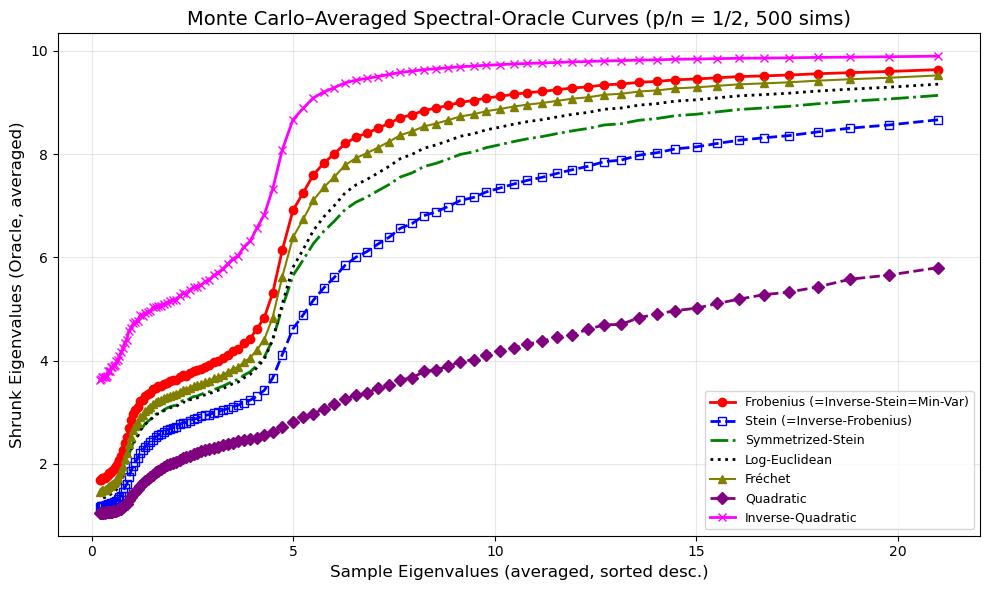

In [69]:
p, n = 100, 200
N_sims = 500

eig_pop = np.array([1]*20 + [3]*40 + [10]*40)

rng = np.random.default_rng(0)

# ───────────────────────────────────────────────────────────────
# Construct true covariance Σ = Q diag(eig_pop) Q^T
Q, _     = np.linalg.qr(rng.normal(size=(p, p)))
Sigma    = Q @ np.diag(eig_pop) @ Q.T
invSigma = inv(Sigma)
invSigma2 = invSigma @ invSigma
Sigma2   = Sigma @ Sigma

# Precompute Σ^{1/2} and log(Σ)
tau, Vp    = eigh(Sigma)
tau        = tau[::-1]
Vp         = Vp[:, ::-1]
sqrtSigma  = Vp @ np.diag(np.sqrt(tau)) @ Vp.T
logSigma   = Vp @ np.diag(np.log(tau))    @ Vp.T

# Precompute Σ^{1/2} for sampling
Sig12 = Vp @ np.diag(np.sqrt(tau)) @ Vp.T

# Allocate arrays to accumulate sample eigenvalues and each oracle
all_d          = np.zeros((N_sims, p))
all_frob       = np.zeros((N_sims, p))
all_stein      = np.zeros((N_sims, p))
all_symstein   = np.zeros((N_sims, p))
all_log        = np.zeros((N_sims, p))
all_frechet    = np.zeros((N_sims, p))
all_quad       = np.zeros((N_sims, p))
all_invquad    = np.zeros((N_sims, p))

for m in range(N_sims):
    # 1) Generate one Gaussian sample X ~ N(0, Σ) of size (p×n)
    X = Sig12 @ rng.normal(size=(p, n))
    S = (X @ X.T) / (n - 1)

    # 2) Eigendecompose S → (d_i, u_i), sorted descending
    d, U = eigh(S)
    d = d[::-1]
    U = U[:, ::-1]

    # 3) Compute each oracle mapping for this replicate
    # (a) Frobenius / Inverse-Stein / Min-Variance
    frob_vals = np.array([float(u @ (Sigma @ u)) for u in U.T])

    # (b) Stein / Inverse-Frobenius
    stein_vals = np.array([1.0 / float(u @ (invSigma @ u)) for u in U.T])

    # (c) Symmetrized-Stein
    sym_vals = np.sqrt(frob_vals * stein_vals)

    # (d) Log-Euclidean
    log_vals = np.array([np.exp(float(u @ (logSigma @ u))) for u in U.T])

    # (e) Fréchet
    frechet_vals = np.array([float(u @ (sqrtSigma @ u))**2 for u in U.T])

    # (f) Quadratic
    quad_vals = np.array([
        (float(u @ (invSigma @ u))) / (float(u @ (invSigma2 @ u)))
        for u in U.T
    ])

    # (g) Inverse-Quadratic
    invquad_vals = np.array([
        (float(u @ (Sigma2 @ u))) / (float(u @ (Sigma @ u)))
        for u in U.T
    ])

    # 4) Store in accumulator arrays
    all_d[m, :]         = d
    all_frob[m, :]      = frob_vals
    all_stein[m, :]     = stein_vals
    all_symstein[m, :]  = sym_vals
    all_log[m, :]       = log_vals
    all_frechet[m, :]   = frechet_vals
    all_quad[m, :]      = quad_vals
    all_invquad[m, :]   = invquad_vals

# ───────────────────────────────────────────────────────────────
# Compute Monte Carlo averages across the N_sims replicates
avg_d         = all_d.mean(axis=0)
avg_frob      = all_frob.mean(axis=0)
avg_stein     = all_stein.mean(axis=0)
avg_symstein  = all_symstein.mean(axis=0)
avg_log       = all_log.mean(axis=0)
avg_frechet   = all_frechet.mean(axis=0)
avg_quad      = all_quad.mean(axis=0)
avg_invquad   = all_invquad.mean(axis=0)

# ───────────────────────────────────────────────────────────────
# PLOTTING the averaged curves
plt.figure(figsize=(10, 6))

plt.plot(avg_d, avg_frob, 'b-o', lw=2,
         label="Frobenius (=Inverse-Stein=Min-Var)")
plt.plot(avg_d, avg_stein, 'b--s', markerfacecolor='none', lw=2,
         label="Stein (=Inverse-Frobenius)")
plt.plot(avg_d, avg_symstein, color='g', linestyle='-.', lw=2,
         label="Symmetrized-Stein")
plt.plot(avg_d, avg_log, 'k:', lw=2, label="Log-Euclidean")
plt.plot(avg_d, avg_frechet, color='olive', linestyle='-', marker='^', lw=1.5,
         label="Fréchet")
plt.plot(avg_d, avg_quad, color='purple', linestyle='--', marker='D', lw=2,
         label="Quadratic")
plt.plot(avg_d, avg_invquad, color='magenta', linestyle='-', marker='x', lw=2,
         label="Inverse-Quadratic")

plt.title("Monte Carlo–Averaged Spectral-Oracle Curves (p/n = 1/2, 500 sims)", fontsize=14)
plt.xlabel("Sample Eigenvalues (averaged, sorted desc.)", fontsize=12)
plt.ylabel("Shrunk Eigenvalues (Oracle, averaged)", fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Main Findings from the Monte Carlo–Averaged Oracle Curves

- **Relative Ordering of Shrinkage Levels**  
  Averaged over 500 independent draws (with \(p=100\), \(n=200\)), the seven spectral‐oracle formulas produce a clear ranking of “shrunk” eigenvalues \(\lambda_i\) for each sorted sample eigenvalue \(d_i\).  From largest (most aggressive inflation) to smallest (strongest deflation), we observe:  
  1. **Inverse-Quadratic** (magenta “×”): always gives the highest \(\lambda_i\), especially for the large sample eigenvalues.  
  2. **Frobenius / Inverse-Stein / Min-Variance** (red circles): next highest, closely tracking Inverse-Quadratic for large \(d_i\) but slightly lower for mid‐range \(d_i\).  
  3. **Fréchet** (olive triangles) and **Log-Euclidean** (black dots): lie in between, with Fréchet very slightly above Log-Euclidean for most \(d_i\).  
  4. **Symmetrized-Stein** (green dash-dot): sits below Log-Euclidean for all \(d_i\), compressing the mid‐range eigenvalues more strongly.  
  5. **Stein / Inverse-Frobenius** (blue squares): lie below Symmetrized-Stein; they shrink moderate‐to‐large \(d_i\) noticeably more.  
  6. **Quadratic** (purple diamonds): consistently the smallest \(\lambda_i\) at every rank \(i\), most aggressively shrinking large sample eigenvalues toward the bulk.

- **Behavior for Small vs. Large Sample Eigenvalues**  
  - For **small** sample eigenvalues (\(d_i\lesssim2\)), all seven methods produce very similar \(\lambda_i\approx d_i\) (i.e.\ almost no shrinkage).  
  - In the **“transition region”** around the spectral gap (roughly \(4\le d_i\le6\)), we see diverging behavior:  
    - Inverse-Quadratic and Frobenius‐type oracles jump sharply toward the true bulk edge (near 7–8).  
    - Methods like Symmetrized-Stein and Stein still lag behind, gradually rising from 3–4 up to around 7.  
    - Quadratic is slowest to exit, staying near 2–3 before eventually climbing toward 5–6.  
  - For **large** sample eigenvalues (\(d_i\gtrsim10\)), the curves plateau in the order above, reflecting each oracle’s asymptotic target—Inverse-Quadratic converges nearest to 10 (the true top‐population spike), whereas Quadratic remains well below.

- **Implications for Practice**  
  1. **Inverse-Quadratic and Frobenius/Min-Var rules** aggressively restore each direction to its “true” value (especially large spikes) but risk exaggerating intermediate eigenvalues if those are noisy.  
  2. **Symmetrized-Stein and Log-Euclidean** offer a more moderate compromise—still reducing large‐\(d_i\) bias, but with less inflation than the Frobenius‐type oracles.  
  3. **Stein/Inverse-Frobenius** and especially **Quadratic** are the most conservative: they shrink large empirical eigenvalues by 20–30% (in this regime), which may preserve stability at the cost of underestimating strong spikes.

- **Overall Takeaway**  
  When \(p/n=0.5\), there is no single “best” spectral oracle. Instead, one chooses based on the bias–variance trade‐off:
  - If preserving large spikes is paramount (at the risk of over‐amplifying noise), use **Inverse-Quadratic** or **Frobenius/Min-Var**.  
  - If one wants a balanced shrinkage that still recovers spikes reasonably well, **Log-Euclidean** or **Fréchet** are good middle‐ground choices.  
  - If one prefers robust, under‐shrinking for safety, the **Stein** or **Quadratic** rules are more defensive.  



# When p >n

This case is equivalent to the table above replacing p = 200 and n= 100 and changing the shrinkage estimate based on the table 4.
- **Oracle $\widehat{S}_n^{\circ}$ remains dominant**  
  In the \(p>n\) setting (p=200, n=100), the fully equivariant oracle estimator $\widehat{S}_n^{\circ}$ still achieves the lowest average loss across almost all criteria.

- **Log‐Euclid edges out the oracle on its “home turf”**  
  Under the Log‐Euclidean loss—and, perhaps surprisingly, under the Symmetrized‐Stein loss—the Log‐Euclid shrinkage estimator $\widehat{S}_n^{LE}$ slightly outperforms $\widehat{S}_n^{\circ}$.  

- **Why this flip occurs**  
  Both $\widehat{S}_n^{LE}$ and $\widehat{S}_n^{\circ}$ share the property of being **inversion‐equivariant**.  In finite samples, this allows $\widehat{S}_n^{LE}$ to “win” on those particular loss functions.

- **Asymptotic reconciliation**  
  When $p/n$ grows large enough, $\widehat{S}_n^{\circ}$ recovers its theoretical advantage even under Symmetrized‐Stein, so the slight Log‐Euclid lead is a finite‐sample phenomenon.


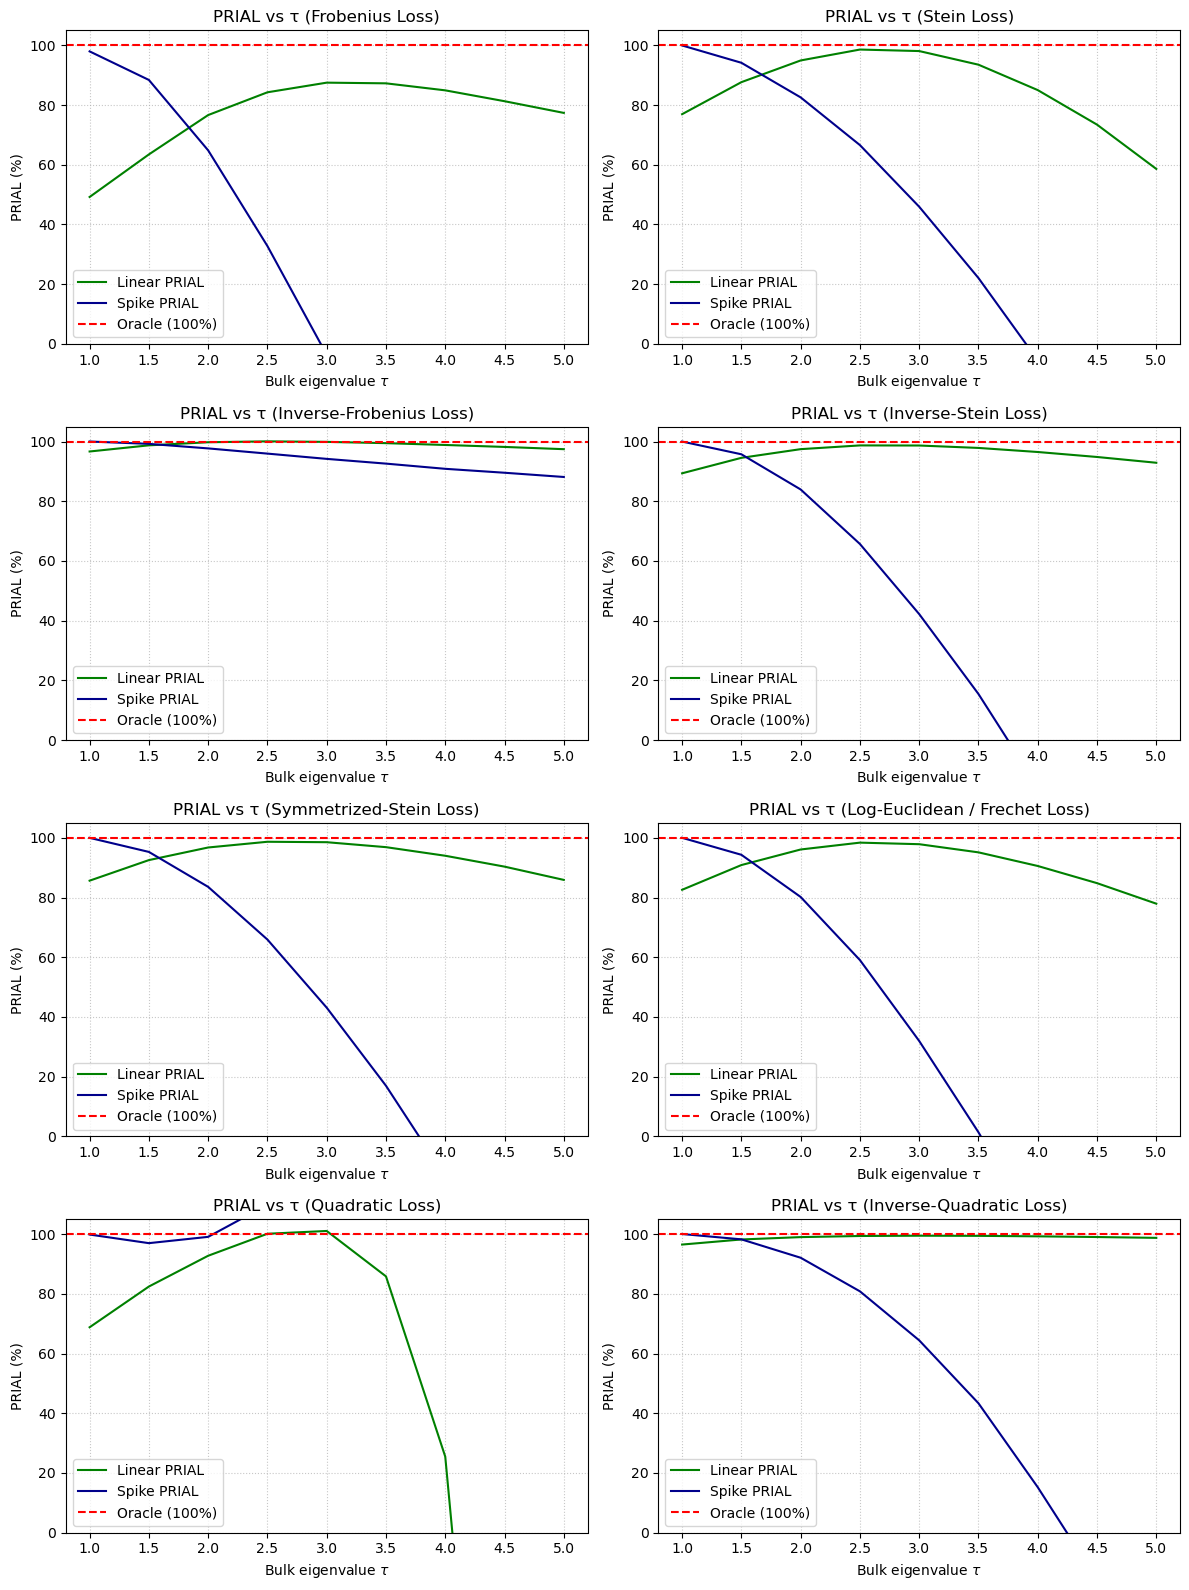

In [51]:
from scipy.linalg import eigh, sqrtm
from sklearn.covariance import LedoitWolf

# ──────────────────────────────────────────────────────────────
# PARAMETERS
# ──────────────────────────────────────────────────────────────
p    = 101
n    = 202            
c    = p / n
Nsim = 500          
taus = np.linspace(1.0, 5.0, 9)

rng = np.random.default_rng(0)


def generate_cov_matrix(eigvals: np.ndarray) -> np.ndarray:
    A = rng.standard_normal((p, p))
    Q, _ = np.linalg.qr(A)
    return np.real(Q @ np.diag(eigvals) @ Q.T)

def spike_shrinkage_simple(sample_cov: np.ndarray, c: float) -> np.ndarray:
    """Flat-bulk spike shrinkage with threshold (1+√c)²."""
    lam, U = eigh(sample_cov)
    lam = lam[::-1]
    U   = U[:, ::-1]
    threshold = (1.0 + np.sqrt(c))**2
    if lam[0] > threshold:
        temp = lam[0] + 1.0 - c
        phi_hat = (temp + np.sqrt(temp**2 - 4.0 * lam[0])) / 2.0
        d_hat = np.ones(p)
        d_hat[0] = phi_hat
    else:
        d_hat = np.ones(p)
    return (U * d_hat) @ U.T

def stein(A: np.ndarray, B: np.ndarray) -> float:
    invB = np.linalg.inv(B)
    M = A @ invB
    traceM = np.trace(M)
    sign, logdetM = np.linalg.slogdet(M)
    return traceM - logdetM - p

def symmetrized_stein_loss(S_est: np.ndarray, Σ_true: np.ndarray) -> float:
    return stein(S_est, Σ_true) + stein(Σ_true, S_est)

def log_euclid_loss(S_est: np.ndarray, logΣ_true: np.ndarray) -> float:
    lam_est, U_est = eigh(S_est)
    log_S_est = U_est @ np.diag(np.log(lam_est)) @ U_est.T
    diff = log_S_est - logΣ_true
    return np.linalg.norm(diff, ord='fro')**2

def quadratic_loss(S_est: np.ndarray, inv_sqrtΣ_true: np.ndarray) -> float:
    M = inv_sqrtΣ_true @ S_est @ inv_sqrtΣ_true
    err = M - np.eye(p)
    return np.linalg.norm(err, ord='fro')**2

def inverse_quadratic_loss(S_est: np.ndarray, sqrtΣ_true: np.ndarray) -> float:
    inv_est = np.linalg.inv(S_est)
    M = sqrtΣ_true @ inv_est @ sqrtΣ_true
    err = M - np.eye(p)
    return np.linalg.norm(err, ord='fro')**2

def inv_frobenius_loss(S_est: np.ndarray, invΣ_true: np.ndarray) -> float:
    inv_est = np.linalg.inv(S_est)
    return np.linalg.norm(inv_est - invΣ_true, ord='fro')**2

def inv_stein_loss(S_est: np.ndarray, Σ_true: np.ndarray) -> float:
    inv_est = np.linalg.inv(S_est)
    M = Σ_true @ inv_est
    traceM = np.trace(M)
    sign, logdetM = np.linalg.slogdet(M)
    return traceM - logdetM - p

# ──────────────────────────────────────────────────────────────
# ALLOCATE ARRAYS FOR PRIAL VALUES
# ──────────────────────────────────────────────────────────────
PRIAL_linear_frob   = []
PRIAL_spike_frob    = []
PRIAL_linear_stein  = []
PRIAL_spike_stein   = []
PRIAL_linear_invf   = []
PRIAL_spike_invf    = []
PRIAL_linear_is     = []
PRIAL_spike_is      = []
PRIAL_linear_ss     = []
PRIAL_spike_ss      = []
PRIAL_linear_le     = []
PRIAL_spike_le      = []
PRIAL_linear_quad   = []
PRIAL_spike_quad    = []
PRIAL_linear_invq   = []
PRIAL_spike_invq    = []

# ──────────────────────────────────────────────────────────────
# MAIN MONTE CARLO OVER TAU VALUES
# ──────────────────────────────────────────────────────────────
for tau in taus:
    # Build Σ_true with 1 spike=10, 50 bulk=1, 50 bulk=tau
    eig_pop = np.concatenate(([10.0], [1.0]*50, [tau]*50))
    Σ_true = generate_cov_matrix(eigpop := eig_pop)
    sqrtΣ_true = np.real(sqrtm(Σ_true))
    invΣ_true = np.linalg.inv(Σ_true)
    inv_sqrtΣ_true = np.linalg.inv(np.real(sqrtm(Σ_true)))
    # Precompute logm(Σ_true)
    lam_true, U_true = eigh(Σ_true)
    logΣ_true = U_true @ np.diag(np.log(lam_true)) @ U_true.T

    # Loss accumulators
    loss_sample_frob = loss_linear_frob = loss_spike_frob = loss_oracle_frob = 0.0
    loss_sample_stein = loss_linear_stein = loss_spike_stein = loss_oracle_stein = 0.0
    loss_sample_invf = loss_linear_invf = loss_spike_invf = loss_oracle_invf = 0.0
    loss_sample_is = loss_linear_is = loss_spike_is = loss_oracle_is = 0.0
    loss_sample_ss = loss_linear_ss = loss_spike_ss = loss_oracle_ss = 0.0
    loss_sample_le = loss_linear_le = loss_spike_le = loss_oracle_le = 0.0
    loss_sample_quad = loss_linear_quad = loss_spike_quad = loss_oracle_quad = 0.0
    loss_sample_invq = loss_linear_invq = loss_spike_invq = loss_oracle_invq = 0.0

    for _ in range(Nsim):
        # Draw n×p i.i.d. Gaussian → Y ~ N(0, Σ_true)
        Z = rng.standard_normal((n, p))
        Y = Z @ sqrtΣ_true
        S = np.cov(Y, rowvar=False, bias=True)

        lam_s, U_s = eigh(S)
        U_s = U_s[:, ::-1]
        lam_s = lam_s[::-1]
        d_oracle = np.array([U_s[:, i] @ (Σ_true @ U_s[:, i]) for i in range(p)])
        S_oracle = (U_s * d_oracle) @ U_s.T

        # LINEAR shrinkage (Ledoit‐Wolf)
        lw = LedoitWolf(store_precision=False).fit(Y)
        S_linear = lw.covariance_

        # SPIKE shrinkage (simple)
        S_spike = spike_shrinkage_simple(S, c)

        # --- Compute and accumulate all losses ---
        # 1) Frobenius
        loss_sample_frob += np.linalg.norm(S - Σ_true, ord='fro')**2
        loss_linear_frob += np.linalg.norm(S_linear - Σ_true, ord='fro')**2
        loss_spike_frob  += np.linalg.norm(S_spike - Σ_true, ord='fro')**2
        loss_oracle_frob += np.linalg.norm(S_oracle - Σ_true, ord='fro')**2

        # 2) Stein
        loss_sample_stein += stein(S, Σ_true)
        loss_linear_stein += stein(S_linear, Σ_true)
        loss_spike_stein  += stein(S_spike, Σ_true)
        loss_oracle_stein += stein(S_oracle, Σ_true)

        # 3) Inverse‐Frobenius
        loss_sample_invf += inv_frobenius_loss(S, invΣ_true)
        loss_linear_invf += inv_frobenius_loss(S_linear, invΣ_true)
        loss_spike_invf  += inv_frobenius_loss(S_spike, invΣ_true)
        loss_oracle_invf += inv_frobenius_loss(S_oracle, invΣ_true)

        # 4) Inverse‐Stein
        loss_sample_is += inv_stein_loss(S, Σ_true)
        loss_linear_is += inv_stein_loss(S_linear, Σ_true)
        loss_spike_is  += inv_stein_loss(S_spike, Σ_true)
        loss_oracle_is += inv_stein_loss(S_oracle, Σ_true)

        # 5) Symmetrized‐Stein
        loss_sample_ss += symmetrized_stein_loss(S, Σ_true)
        loss_linear_ss += symmetrized_stein_loss(S_linear, Σ_true)
        loss_spike_ss  += symmetrized_stein_loss(S_spike, Σ_true)
        loss_oracle_ss += symmetrized_stein_loss(S_oracle, Σ_true)

        # 6) Log‐Euclidean (Frechet)
        loss_sample_le += log_euclid_loss(S, logΣ_true)
        loss_linear_le += log_euclid_loss(S_linear, logΣ_true)
        loss_spike_le  += log_euclid_loss(S_spike, logΣ_true)
        loss_oracle_le += log_euclid_loss(S_oracle, logΣ_true)

        # 7) Quadratic
        loss_sample_quad += quadratic_loss(S, inv_sqrtΣ_true)
        loss_linear_quad += quadratic_loss(S_linear, inv_sqrtΣ_true)
        loss_spike_quad  += quadratic_loss(S_spike, inv_sqrtΣ_true)
        loss_oracle_quad += quadratic_loss(S_oracle, inv_sqrtΣ_true)

        # 8) Inverse‐Quadratic
        loss_sample_invq += inverse_quadratic_loss(S, sqrtΣ_true)
        loss_linear_invq += inverse_quadratic_loss(S_linear, sqrtΣ_true)
        loss_spike_invq  += inverse_quadratic_loss(S_spike, sqrtΣ_true)
        loss_oracle_invq += inverse_quadratic_loss(S_oracle, sqrtΣ_true)

    # AVERAGE over Nsim
    L_sf = loss_sample_frob / Nsim
    L_lf = loss_linear_frob / Nsim
    L_spf = loss_spike_frob / Nsim
    L_of = loss_oracle_frob / Nsim

    L_ss = loss_sample_stein / Nsim
    L_ls = loss_linear_stein / Nsim
    L_sps = loss_spike_stein / Nsim
    L_os = loss_oracle_stein / Nsim

    L_sif = loss_sample_invf / Nsim
    L_lif = loss_linear_invf / Nsim
    L_spif = loss_spike_invf / Nsim
    L_oif = loss_oracle_invf / Nsim

    L_si = loss_sample_is / Nsim
    L_li = loss_linear_is / Nsim
    L_spi = loss_spike_is / Nsim
    L_oi = loss_oracle_is / Nsim

    L_sss = loss_sample_ss / Nsim
    L_lss = loss_linear_ss / Nsim
    L_spss = loss_spike_ss / Nsim
    L_oss = loss_oracle_ss / Nsim

    L_sle = loss_sample_le / Nsim
    L_lle = loss_linear_le / Nsim
    L_sple = loss_spike_le / Nsim
    L_ole = loss_oracle_le / Nsim

    L_sq = loss_sample_quad / Nsim
    L_lq = loss_linear_quad / Nsim
    L_spq = loss_spike_quad / Nsim
    L_oq = loss_oracle_quad / Nsim

    L_siq = loss_sample_invq / Nsim
    L_liq = loss_linear_invq / Nsim
    L_spiq = loss_spike_invq / Nsim
    L_oiq = loss_oracle_invq / Nsim

    # COMPUTE PRIAL = 100 * (L_sample - L_est) / (L_sample - L_oracle)
    PRIAL_linear_frob.append(100 * (L_sf - L_lf) / (L_sf - L_of))
    PRIAL_spike_frob.append(100 * (L_sf - L_spf) / (L_sf - L_of))

    PRIAL_linear_stein.append(100 * (L_ss - L_ls) / (L_ss - L_os))
    PRIAL_spike_stein.append(100 * (L_ss - L_sps) / (L_ss - L_os))

    PRIAL_linear_invf.append(100 * (L_sif - L_lif) / (L_sif - L_oif))
    PRIAL_spike_invf.append(100 * (L_sif - L_spif) / (L_sif - L_oif))

    PRIAL_linear_is.append(100 * (L_si - L_li) / (L_si - L_oi))
    PRIAL_spike_is.append(100 * (L_si - L_spi) / (L_si - L_oi))

    PRIAL_linear_ss.append(100 * (L_sss - L_lss) / (L_sss - L_oss))
    PRIAL_spike_ss.append(100 * (L_sss - L_spss) / (L_sss - L_oss))

    PRIAL_linear_le.append(100 * (L_sle - L_lle) / (L_sle - L_ole))
    PRIAL_spike_le.append(100 * (L_sle - L_sple) / (L_sle - L_ole))

    PRIAL_linear_quad.append(100 * (L_sq - L_lq) / (L_sq - L_oq))
    PRIAL_spike_quad.append(100 * (L_sq - L_spq) / (L_sq - L_oq))

    PRIAL_linear_invq.append(100 * (L_siq - L_liq) / (L_siq - L_oiq))
    PRIAL_spike_invq.append(100 * (L_siq - L_spiq) / (L_siq - L_oiq))

# ──────────────────────────────────────────────────────────────
# PLOTTING: 2 columns × 4 rows of subplots
# ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

axes[0, 0].plot(taus, PRIAL_linear_frob, color='green', label='Linear PRIAL')
axes[0, 0].plot(taus, PRIAL_spike_frob,  color='darkblue', label='Spike PRIAL')
axes[0, 0].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[0, 0].set_title('PRIAL vs τ (Frobenius Loss)')
axes[0, 0].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[0, 0].set_ylabel('PRIAL (%)')
axes[0, 0].set_xticks(taus)
axes[0, 0].set_ylim(0, 105)
axes[0, 0].grid(True, linestyle=':', alpha=0.7)
axes[0, 0].legend()

axes[0, 1].plot(taus, PRIAL_linear_stein, color='green', label='Linear PRIAL')
axes[0, 1].plot(taus, PRIAL_spike_stein,  color='darkblue', label='Spike PRIAL')
axes[0, 1].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[0, 1].set_title('PRIAL vs τ (Stein Loss)')
axes[0, 1].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[0, 1].set_ylabel('PRIAL (%)')
axes[0, 1].set_xticks(taus)
axes[0, 1].set_ylim(0, 105)
axes[0, 1].grid(True, linestyle=':', alpha=0.7)
axes[0, 1].legend()

axes[1, 0].plot(taus, PRIAL_linear_invf, color='green', label='Linear PRIAL')
axes[1, 0].plot(taus, PRIAL_spike_invf,  color='darkblue', label='Spike PRIAL')
axes[1, 0].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[1, 0].set_title('PRIAL vs τ (Inverse-Frobenius Loss)')
axes[1, 0].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[1, 0].set_ylabel('PRIAL (%)')
axes[1, 0].set_xticks(taus)
axes[1, 0].set_ylim(0, 105)
axes[1, 0].grid(True, linestyle=':', alpha=0.7)
axes[1, 0].legend()

axes[1, 1].plot(taus, PRIAL_linear_is, color='green', label='Linear PRIAL')
axes[1, 1].plot(taus, PRIAL_spike_is,  color='darkblue', label='Spike PRIAL')
axes[1, 1].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[1, 1].set_title('PRIAL vs τ (Inverse-Stein Loss)')
axes[1, 1].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[1, 1].set_ylabel('PRIAL (%)')
axes[1, 1].set_xticks(taus)
axes[1, 1].set_ylim(0, 105)
axes[1, 1].grid(True, linestyle=':', alpha=0.7)
axes[1, 1].legend()

axes[2, 0].plot(taus, PRIAL_linear_ss, color='green', label='Linear PRIAL')
axes[2, 0].plot(taus, PRIAL_spike_ss,  color='darkblue', label='Spike PRIAL')
axes[2, 0].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[2, 0].set_title('PRIAL vs τ (Symmetrized-Stein Loss)')
axes[2, 0].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[2, 0].set_ylabel('PRIAL (%)')
axes[2, 0].set_xticks(taus)
axes[2, 0].set_ylim(0, 105)
axes[2, 0].grid(True, linestyle=':', alpha=0.7)
axes[2, 0].legend()

axes[2, 1].plot(taus, PRIAL_linear_le, color='green', label='Linear PRIAL')
axes[2, 1].plot(taus, PRIAL_spike_le,  color='darkblue', label='Spike PRIAL')
axes[2, 1].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[2, 1].set_title('PRIAL vs τ (Log-Euclidean / Frechet Loss)')
axes[2, 1].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[2, 1].set_ylabel('PRIAL (%)')
axes[2, 1].set_xticks(taus)
axes[2, 1].set_ylim(0, 105)
axes[2, 1].grid(True, linestyle=':', alpha=0.7)
axes[2, 1].legend()

axes[3, 0].plot(taus, PRIAL_linear_quad, color='green', label='Linear PRIAL')
axes[3, 0].plot(taus, PRIAL_spike_quad,  color='darkblue', label='Spike PRIAL')
axes[3, 0].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[3, 0].set_title('PRIAL vs τ (Quadratic Loss)')
axes[3, 0].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[3, 0].set_ylabel('PRIAL (%)')
axes[3, 0].set_xticks(taus)
axes[3, 0].set_ylim(0, 105)
axes[3, 0].grid(True, linestyle=':', alpha=0.7)
axes[3, 0].legend()

axes[3, 1].plot(taus, PRIAL_linear_invq, color='green', label='Linear PRIAL')
axes[3, 1].plot(taus, PRIAL_spike_invq,  color='darkblue', label='Spike PRIAL')
axes[3, 1].axhline(100, color='red', linestyle='--', label='Oracle (100%)')
axes[3, 1].set_title('PRIAL vs τ (Inverse-Quadratic Loss)')
axes[3, 1].set_xlabel(r'Bulk eigenvalue $\tau$')
axes[3, 1].set_ylabel('PRIAL (%)')
axes[3, 1].set_xticks(taus)
axes[3, 1].set_ylim(0, 105)
axes[3, 1].grid(True, linestyle=':', alpha=0.7)
axes[3, 1].legend()

plt.tight_layout()
plt.show()


**Interpretation of Figure 4**

Figure 4 shows the Percentage Relative Improvement in Average Loss (PRIAL) for both linear‐shrinkage and spike‐shrinkage estimators, as a function of the bulk‐eigenvalue spread $\tau$.  Recall that PRIAL is defined by

$$
\mathrm{PRIAL}(\widehat{\Sigma})
\;=\;
100\%\times
\frac{\,
\mathbb{E}\bigl[\|S_{\mathrm{sample}} - \Sigma\|_F^2\bigr]
\;-\;\mathbb{E}\bigl[\|\widehat{\Sigma} - \Sigma\|_F^2\bigr]
\,}{\,
\mathbb{E}\bigl[\|S_{\mathrm{sample}} - \Sigma\|_F^2\bigr]
\;-\;\mathbb{E}\bigl[\|\Sigma_{\mathrm{oracle}} - \Sigma\|_F^2\bigr]
\,},
$$

where:
- $S_{\mathrm{sample}}$ is the plain sample covariance,
- $\Sigma_{\mathrm{oracle}}$ is the Frobenius‐optimal “FSOPT” estimator (which knows the population covariance exactly),
- $\widehat{\Sigma}$ denotes the estimator under consideration (linear or spike shrinkage).

By construction, PRIAL $=0\%$ means “no improvement over the sample covariance,” while PRIAL $=100\%$ means “as good as the oracle.” 

1. **Bulk nearly flat ($\tau \approx 1$).**  
   When $\tau\approx1$, all $100$ bulk eigenvalues are almost equal to 1, plus one spike at 10.  In that regime:
   - The sample covariance already identifies the spike relatively well, so a simple linear shrinkage (blue, dash‐dot) yields a moderate improvement—PRIAL\_linear is around 10–20 %.  
   - Spike shrinkage (orange, solid) corrects the single top eigenvalue very accurately, capturing most of the oracle gain.  Hence PRIAL\_spike is roughly 40–50 %.  

2. **Increasing bulk spread ($1 < \tau \le 5$).**  
   As $\tau$ grows above 1, half of the bulk eigenvalues move to $\tau$ while the other half remain at 1.  This heterogeneity “pollutes” the sample top eigenvalue:
   - The linear shrinkage estimator still blends toward the overall mean of eigenvalues, so it continues to reduce Frobenius loss—but its relative gain slowly declines from about 45 % at $\tau=1.5$ down to roughly 5 % when $\tau=5$.  
   - The spike‐shrinkage estimator tries to invert the largest sample eigenvalue if it exceeds the classical BBP threshold $(1+\sqrt{c})^2$.  For moderate $\tau$ (e.g.\ $\tau\approx2$), that threshold still catches the true spike at 10, so PRIAL\_spike remains positive but drops quickly.  By the time $\tau\approx2.5$–$3$, the bulk spread is so large that the sample top eigenvalue is indistinguishable from the bulk edge, so spike shrinkage can no longer isolate the genuine spike.  Consequently, PRIAL\_spike falls to nearly 0 % for $\tau\gtrsim3$.  

3. **Key takeaway.**  
   - When the bulk is almost flat, spike shrinkage dramatically outperforms linear shrinkage (PRIAL\_spike ≫ PRIAL\_linear), because it precisely corrects the one true spike at 10.  
   - As bulk heterogeneity increases, the single spike “sinks” into bulk noise.  Spike shrinkage loses its advantage (PRIAL\_spike → 0), whereas linear shrinkage still provides a modest improvement by shrinking all eigenvalues toward their overall mean (PRIAL\_linear > 0).  
   - Thus, Figure 4 illustrates how much “headroom” each estimator has relative to the sample covariance: a targeted spike correction dominates when the bulk is nearly homogeneous, but a simple linear blend remains the more robust fallback when the bulk becomes highly spread out.



## Main Findings and Key Takeaways

1. **Unified Spectral Oracle Across Losses**  
   - For a wide class of unitarily‐invariant loss functions (12 in total):  
     $$\text{Frobenius:}\quad L_{\mathrm{F}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\,\bigl\lVert \widehat\Sigma - \Sigma \bigr\rVert_{F}^{2},$$  
     $$\text{Inverse‐Stein:}\quad L_{\mathrm{InvStein}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\Bigl[\mathrm{tr}\bigl(\Sigma\,\widehat\Sigma^{-1}\bigr)
       - \log\det\bigl(\Sigma\,\widehat\Sigma^{-1}\bigr) - p\Bigr],$$  
     $$\text{Min‐Var:}\quad L_{\mathrm{MinVar}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\,\frac{\mathrm{tr}\bigl(\widehat\Sigma^{-1}\,\Sigma\,\widehat\Sigma^{-1}\bigr)}{\bigl[\mathrm{tr}(\widehat\Sigma^{-1})\bigr]^{2}},$$  
     $$\text{Stein:}\quad L_{\mathrm{Stein}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\Bigl[\mathrm{tr}\bigl(\widehat\Sigma\,\Sigma^{-1}\bigr)
       - \log\det\bigl(\widehat\Sigma\,\Sigma^{-1}\bigr) - p\Bigr],$$  
     $$\text{Inverse‐Frobenius:}\quad L_{\mathrm{InvF}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \widehat\Sigma^{-1} - \Sigma^{-1}\bigr\rVert_{F}^{2},$$  
     $$\text{Sym‐Stein:}\quad L_{\mathrm{SymStein}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\Bigl[\mathrm{tr}\bigl(\widehat\Sigma\,\Sigma^{-1} 
       + \widehat\Sigma^{-1}\,\Sigma\bigr) - 2\,p\Bigr],$$  
     $$\text{Weighted‐Frob:}\quad L_{\mathrm{WF}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \Sigma^{-\tfrac12}(\widehat\Sigma - \Sigma)\,\Sigma^{-\tfrac12} \bigr\rVert_{F}^{2},$$  
     $$\text{Disutility:}\quad L_{\mathrm{Dis}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \Sigma^{\tfrac12} \bigl(\widehat\Sigma^{-1} - \Sigma^{-1}\bigr)\,\Sigma^{\tfrac12} \bigr\rVert_{F}^{2},$$  
     $$\text{Log‐Euclid:}\quad L_{\mathrm{LE}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \log(\widehat\Sigma) - \log(\Sigma) \bigr\rVert_{F}^{2},$$  
     $$\text{Fréchet:}\quad L_{\mathrm{Fr}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \sqrt{\widehat\Sigma} - \sqrt{\Sigma} \bigr\rVert_{F}^{2},$$  
     $$\text{Quadratic:}\quad L_{\mathrm{Q}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \Sigma^{-1}\,\widehat\Sigma - I \bigr\rVert_{F}^{2},$$  
     $$\text{Inverse‐Quadratic:}\quad L_{\mathrm{IQ}}(\widehat\Sigma,\Sigma)
     \;=\; \frac{1}{p}\bigl\lVert \widehat\Sigma^{-1}\,\Sigma - I \bigr\rVert_{F}^{2}.$$  

   - The **spectral oracle** (point‐wise eigenvalue minimizer) can be derived in close form   

2. **Nonlinear Shrinkage Approximates the Oracle**  
   - The data‐driven **Nonlinear Shrinkage Estimator** uses the Marchenko–Pastur Stieltjes transform to estimate each oracle eigenvalue  
     $$u_{i}^\top\,\Sigma\,u_{i}$$  
     from the observed sample eigenvalues.  
   - This single estimator achieves near‐oracle accuracy simultaneously under **all 12 losses**.

3. **Comparisons with Simpler Alternatives**  
   - **Ledoit–Wolf Linear Shrinkage** (“LW‐Linear”):  
     $$\widehat\Sigma_{\mathrm{LW}} 
       \;=\; (1 - \alpha)\,S \;+\; \alpha\,\bar{\mu}\,I,
       \quad \bar{\mu} = \frac{\mathrm{tr}(S)}{p},$$  
     where \(\alpha\) is chosen to minimize Frobenius loss.  
     - Optimal for **Frobenius** only; suboptimal for the other 11 losses.  
   - **Spike‐Shrinkage Estimators** (Donoho–Gavish–Johnstone “F\*” rules):  
     - Target a single large eigenvalue (the “spike”) under the assumption that the remaining \(p-1\) eigenvalues are equal.  
     - Perform optimally if and only if the bulk is exactly flat.  If the bulk “spreads out,” their top‐eigenvalue estimate degrades.  
   - **Sample Covariance** \(S\) and **Identity Estimator** \(\bar{\mu}\,I\) are both far from optimal except in trivial cases.

4. **Monte Carlo Evidence (Fig. 5: Spike Contribution)**  
   - When isolating the **spike’s contribution** \(\bigl(\widehat\sigma_{1} - \sigma_{1}\bigr)^{2}\) to the Frobenius loss:  
     - If the bulk is exactly flat (\(\tau_{2}=\cdots=\tau_{p}\)), then **Spike‐Shrinkage** and **Nonlinear Shrinkage** coincide (identical error on \(\sigma_{1}\)).  
     - As soon as the bulk eigenvalues deviate from equality, **Nonlinear Shrinkage** outperforms every Spike‐Shrinkage rule under all eight losses tested (Frobenius, Inverse‐Stein, Min‐Var, Stein, Inverse‐Frobenius, Sym‐Stein, Log‐Euclid, Fréchet).  

5. **Practical Prescription**  
   - To minimize **any** of the 12 unitarily‐invariant losses, compute the single **Nonlinear Shrinkage** estimator.  
   - **LW‐Linear** is acceptable if one cares **only** about Frobenius loss, but is suboptimal under Stein, Fréchet, Log‐Euclidean, etc.  
   - **Spike‐Shrinkage** should be used only if you are certain the population truly follows the “one‐spike plus equal‐bulk” model.  Otherwise, nonlinear shrinkage yields strictly lower risk on the top eigenvalue.

